<a href="https://www.kaggle.com/code/pierremonroy/september-tabular-playground-eda-sarima?scriptVersionId=105689285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import seaborn as sns
from itertools import product

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import statsmodels.api as sm

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-sep-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-sep-2022/train.csv
/kaggle/input/tabular-playground-series-sep-2022/test.csv


In [10]:
# !pip install kats

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [11]:
train = pd.read_csv('../input/tabular-playground-series-sep-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-sep-2022/test.csv')

In [12]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])

## EDA

We basically have 4 dimensions under which we need to explore the data:
* time
* country
* store
* product

Given the categorical nature of the data, the most obvious would be to have a time series plot of each product's sales for each location (country + store) so 12 plots in total with 4 lines on each.

In [ ]:
train

In [ ]:
train.describe()

In [ ]:
test.describe()

In [ ]:
test.head()

#### Checking if any NA

In [ ]:
train.isna().sum()

In [ ]:
test.isna().sum()

#### Checking categorical unique values in train and test sets

In [ ]:
print(train['product'].unique())

In [ ]:
print(test['product'].unique())

In [ ]:
print(train['country'].unique())

In [ ]:
print(test['country'].unique())

In [ ]:
print(train['store'].unique())

In [ ]:
print(test['store'].unique())

In [ ]:
train['product'].unique()

#### Simplifying data handling by renaming products

In [13]:
train.loc[train['product']=='Kaggle Advanced Techniques','product'] = 'A'
train.loc[train['product']=='Kaggle Getting Started','product'] = 'B'
train.loc[train['product']=='Kaggle Recipe Book','product'] = 'C'
train.loc[train['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [14]:
test.loc[test['product']=='Kaggle Advanced Techniques','product'] = 'A'
test.loc[test['product']=='Kaggle Getting Started','product'] = 'B'
test.loc[test['product']=='Kaggle Recipe Book','product'] = 'C'
test.loc[test['product']=='Kaggle for Kids: One Smart Goose','product'] = 'D'

In [15]:
prods = train['product'].unique()
countries = train['country'].unique()
stores = train['store'].unique()

In [ ]:
all_combinations = [x for x in product(countries, prods, stores)]

_, axs = plt.subplots(6,8, figsize=(32,32))

for x, ax in zip(all_combinations, axs.ravel()):
    tmp_train = train[(train['country'] == x[0]) & (train['product'] == x[1]) & (train['store'] == x[2])]

    mi = tmp_train['num_sold'].min()
    ma = tmp_train['num_sold'].max()
    bins = np.linspace(mi, ma, 50)
    ax.hist(tmp_train['num_sold'], bins=bins, alpha=0.5, density=True, label='train')
#     ax.set_ylabel(x[0])
    ax.set_title('{c}, product {p}, {s}'.format(c=x[0], p=x[1], s=x[2]))
    
plt.show()

In [ ]:
train.dtypes

In [ ]:
_, axs = plt.subplots(6,2, figsize=(32,32))

for x, ax in zip([x for x in product(countries, stores)], axs.ravel()):

    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'A') & (train['store'] == x[1]) & (train['country'] == x[0])], label="A",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'B') & (train['store'] == x[1]) & (train['country'] == x[0])], label="B",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'C') & (train['store'] == x[1]) & (train['country'] == x[0])], label="C",ax=ax)
    sns.lineplot(x='date', y='num_sold', data=train[(train['product'] == 'D') & (train['store'] == x[1]) & (train['country'] == x[0])], label="D",ax=ax)
    ax.set_title('Country {c}, store {s}'.format(c=x[0], s=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [ ]:
_, axs = plt.subplots(3,2, figsize=(32,32))

for x, ax in zip(countries, axs.ravel()):
    tmp_df = train[train['country'] == x].groupby(['date','product']).sum().unstack(1)
    sns.lineplot(x='date', y='A', data=tmp_df['num_sold'], label="A",ax=ax)
    sns.lineplot(x='date', y='B', data=tmp_df['num_sold'], label="B",ax=ax)
    sns.lineplot(x='date', y='C', data=tmp_df['num_sold'], label="C",ax=ax)
    sns.lineplot(x='date', y='D', data=tmp_df['num_sold'], label="D",ax=ax)
    ax.set_title('Country {c}'.format(c=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [ ]:
tmp_df = train.groupby(['date','country']).sum().unstack(1)['num_sold']

plt.figure(figsize=(20,12))

for country in countries:
    sns.lineplot(x='date', y=country, data=tmp_df, label=country)

plt.title('Sales by Country')
plt.show()

### Stores Sales Ratio

Reproducing here the store ratio approach by https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach#EDA


In [ ]:
train_gp = train.set_index('date').loc[:'2020-01-01',:].groupby(['date','store']).sum().unstack(1)['num_sold']
train_gp['ratio'] = train_gp['KaggleMart'] / (train_gp['KaggleMart'] + train_gp['KaggleRama'])
train_gp['ratio'].plot()
plt.title('Ratio of KaggleMart Sales over All Stores Sales')
plt.show()

In [ ]:
train_gp['ratio']

In [ ]:
train_gp['ratio'].mean()

### Product Sales Ratio by Country

Reproducing here the store ratio approach by https://www.kaggle.com/code/ehekatlact/tps2209-ridge-lgbm-eda-topdownapproach#EDA


In [ ]:
_, axs = plt.subplots(3,2, figsize=(32,32))

for x, ax in zip(countries, axs.ravel()):
    tmp_df = train.set_index('date').loc[:'2020-01-01',:].groupby(['date','country','product']).sum().unstack([1,2])['num_sold'][x]
    tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
    sns.lineplot(x='date', y='A', data=tmp_df, label="A",ax=ax)
    sns.lineplot(x='date', y='B', data=tmp_df, label="B",ax=ax)
    sns.lineplot(x='date', y='C', data=tmp_df, label="C",ax=ax)
    sns.lineplot(x='date', y='D', data=tmp_df, label="D",ax=ax)
    ax.set_title('Country {c}'.format(c=x))
    ax.set_ylabel('Sales Share of Total')
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

### Fourier Transform

Apart from a clear weekly seasonality, which we can model by adding day of the week indicator variables, it's hard to generalize seasonal observation from the periodograms but we could experiment with adding Fourier pairs to model seasonality in a regression.

In [ ]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [ ]:
_, axs = plt.subplots(6,4, figsize=(32,32))

for x, ax in zip(product(countries, prods), axs.ravel()):
    tmp_df = train[(train['country'] == x[0])].groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x[1]], ax=ax)
    ax.set_title('Country {c}, product {p}'.format(c=x[0], p=x[1]))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

In [ ]:
_, axs = plt.subplots(2,2, figsize=(16,16))

for x, ax in zip(prods, axs.ravel()):
    tmp_df = train.groupby(['date','product']).sum().unstack(1).loc[:'2020-01-01','num_sold']
    plot_periodogram(tmp_df[x], ax=ax)
    ax.set_title('Product {p}'.format(p=x))
    ax.legend()
    plt.xticks(rotation=45)
plt.show()

## Modelling 

* SARIMA
* Regression
 * Create day of the week and months features to capture seasonality
 * Add Fourier pairs

### Feature engineering

In [ ]:
train['weekday'] = train['date'].apply(lambda x: x.weekday())
train['month'] = train['date'].apply(lambda x: x.month)

test['weekday'] = test['date'].apply(lambda x: x.weekday())
test['month'] = test['date'].apply(lambda x: x.month)

### SARIMA approach

This was my first approach when looking at the data. The rationale being that:
* Data is time series
* We identified seasonality
* As it is the data is clearly not stationary so we need to differentiate at least by order 1

The conclusion after running this approach is that is does not perform very well in terms of SMAPE score.

In [ ]:
# import statsmodels.api as sm
# from pylab import rcParams
# rcParams['figure.figsize'] = 18, 8
# decomposition = sm.tsa.seasonal_decompose(y, model='additive', period = 30)
# fig = decomposition.plot()
# plt.show()

In [ ]:
p = range(0, 2, 1)
d = 1
q = range(0, 2, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 30
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['params', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

def SARIMA_forecast(df):
    result_df = optimize_SARIMA(parameters_list, 1, 0, 30,df['num_sold'])
    p = result_df['params'].iloc[0]
    mod = SARIMAX(df['num_sold'],order=(p[0], 1, p[1]),
                seasonal_order=(p[2], 1, p[3], 30),
                enforce_stationarity=False,
                enforce_invertibility=False)
    res = mod.fit(disp=False)
    pred = res.get_forecast(steps = 365)
    
    return pred.predicted_mean, p

In [ ]:
if False: ### Toggle to avoid running as it's very long

    for x in product(countries, stores, prods):
        df = train[(train['country'] == x[0]) & (train['store'] == x[1]) & (train['product'] == x[2])]
        df = df.set_index('date').asfreq('D')

        pred, p = SARIMA_forecast(df)
        print('Combinations ({c}, {s}, {p}), optimal SARIMA params {params}'.format(c=x[0], s=x[1], p=x[2], params=p))

        new_index = test[(test['country'] == x[0]) & (test['store'] == x[1]) & (test['product'] == x[2])].index
        pred = pd.DataFrame(pred).set_index(new_index)

        if 'predicted_mean' in test.columns:
            test.loc[new_index,'predicted_mean'] = pred.loc[new_index,'predicted_mean']
        else:
            test = test.join(pred, how='left')
            
    test[['row_id','predicted_mean']].rename(columns={'predicted_mean':'num_sold'}).set_index('row_id').to_csv('submission.csv')

### Regression approach

As done in other notebooks, we will predict total sales. Assign an equal number of sales to each country. Then we will use regression models to predict the share of each product in a given country's sales. Finally, we will split product's sales between KaggleRama and KaggleMart using the more or less constant ratio observed.

Note post run: approach using SARIMA to forecast total sales does not seem to perform well. Also creating the exogeneous data set using CalendarFourier and DeterministicPRocess does not improve the score. Maybe better to use the weekday and month categorical variables I have createed + one hot encoding.

#### V1

In [ ]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')
pred, p = SARIMA_forecast(train_tot)

In [ ]:
pred = pd.DataFrame(pred)

for c in countries:
    pred[c] = pred['predicted_mean'] / 6.0

In [ ]:
### Reusing code from Kaggle Course: https://www.kaggle.com/code/ryanholbrook/seasonality

if False:
    # train_gp = train[(train.date < '2020-01-01') | (train.date > '2020-07-01')].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']
    train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']
    fourier = CalendarFourier(freq="A", order=2)  # 2 sin/cos pairs

    all_res = {}

    for c in countries:
        tmp_df = train_gp[c]
        tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
        all_res[c] = pd.DataFrame([], index=pred.index)
        for p in prods:
            y = tmp_df[[p]]

            dp = DeterministicProcess(
                index=y.index,
                constant=True,               # dummy feature for bias (y-intercept)
                order=1,                     # trend (order 1 means linear)
                seasonal=True,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )
            X = dp.in_sample()
            mod = sm.OLS(y,X)
            res = mod.fit()

            dp2 = DeterministicProcess(
                index=pred.index,
                constant=True,               # dummy feature for bias (y-intercept)
                order=1,                     # trend (order 1 means linear)
                seasonal=True,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )
            X_test = dp2.in_sample()
            all_res[c][p] = res.predict(X_test)


In [ ]:
if False:
    for key in all_res.keys():
        all_res[key] = all_res[key].mul(pred[key],axis=0)

    ratios = {'KaggleMart':0.7424903876815521, 'KaggleRama': 1 - 0.7424903876815521}

    test['num_sold'] = 0

    for i in range(test.shape[0]):
        test['num_sold'].iloc[i] = all_res[test['country'].iloc[i]][test['product'].iloc[i]].loc[test['date'].iloc[i]] * ratios[test['store'].iloc[i]]

    test[['row_id', 'num_sold']].set_index('row_id').to_csv('submission.csv')

#### V2

Let's try a few different regression models to forecast total sales. Keep the equi-weighted split by county approach then experiment with a few other regression models for the share of product sales by country. Finally the ratio approach also stays the same for now.

In [ ]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')]
train_tot['weekday'] = train_tot['date'].apply(lambda x: x.weekday())
train_tot['month'] = train_tot['date'].apply(lambda x: x.month)
train_tot['year'] = train_tot['date'].apply(lambda x: x.year)

In [ ]:
### Still want to generate some Fourier pairs
fourier = CalendarFourier(freq="2A", order=4)  # 2 sin/cos pairs

dp = DeterministicProcess(
            index=train_tot.set_index('date').asfreq('D').index,
            constant=False,               # dummy feature for bias (y-intercept)
            order=0,                     # trend (order 1 means linear)
            seasonal=False,               # weekly seasonality (indicators)
            additional_terms=[fourier],  # annual seasonality (fourier)
            drop=True                    # drop terms to avoid collinearity
        )

X0 = dp.in_sample().rename(columns={'sin(1,freq=2A-DEC)':'pair1','cos(1,freq=2A-DEC)':'pair2','sin(2,freq=2A-DEC)':'pair3','cos(2,freq=2A-DEC)':'pair4'})
train_tot = train_tot.join(X0, on='date', how='left')

In [ ]:
dp.in_sample()

In [ ]:
X = train_tot[["weekday", "month", "year","pair1", "pair2", "pair3", "pair4"]]
y = train_tot["num_sold"]

categorical_features = ["weekday", "month", "year"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
)

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("model MSE: %.3f" % mean_squared_error(y_pred, y_test))  # using MSE to penalize large errors

In [ ]:
X = train_tot[["weekday", "month", "year","pair1", "pair2", "pair3", "pair4"]]
y = train_tot["num_sold"]

categorical_features = ["weekday", "month", "year"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", SVR())]
)

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [ ]:
X = train_tot[["weekday", "month", "year","pair1", "pair2", "pair3", "pair4"]]
y = train_tot["num_sold"]

categorical_features = ["weekday", "month", "year"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", Ridge())]
)

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [ ]:
X = train_tot[["weekday", "month", "year"]]
y = train_tot["num_sold"]

categorical_features = ["weekday", "month", "year"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", Ridge())]
)

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("model MSE: %.3f" % mean_squared_error(y_pred, y_test)) # using MSE to penalize large errors

In [ ]:
test_tot = test.groupby('date').sum()
test_tot = test_tot.reset_index()
test_tot['weekday'] = test_tot['date'].apply(lambda x: x.weekday())
test_tot['month'] = test_tot['date'].apply(lambda x: x.month)
test_tot['year'] = test_tot['date'].apply(lambda x: x.year)
X_test = test_tot[["weekday", "month", "year"]]

In [ ]:
clf.fit(X, y)
test_pred = clf.predict(X_test)

In [ ]:
plt.plot(test_pred)

In [ ]:
test_pred = pd.DataFrame(test_pred, columns=['total_sales'],index=test_tot.set_index('date').asfreq('D').index)

for c in countries:
    test_pred[c] = test_pred['total_sales'] / 6.0

Ridge regression definitely seems to have lower MSE than the two other models I experimented with (XGBoost and SVM). In addition, it seems that the Fourier pairs don't add any explanatory power (need to double check, not sure why). Ideally I would like to perform CV at some point to fine tune the Ridge hyper parameters.

In [ ]:
def createPairs(idx,df):
    fourier = CalendarFourier(freq="2A", order=2)  # 2 sin/cos pairs

    dp = DeterministicProcess(
                index=train_tot.set_index('date').asfreq('D').index,
                constant=False,               # dummy feature for bias (y-intercept)
                order=0,                     # trend (order 1 means linear)
                seasonal=False,               # weekly seasonality (indicators)
                additional_terms=[fourier],  # annual seasonality (fourier)
                drop=True                    # drop terms to avoid collinearity
            )

    X0 = dp.in_sample().rename(columns={'sin(1,freq=2A-DEC)':'pair1','cos(1,freq=2A-DEC)':'pair2','sin(2,freq=2A-DEC)':'pair3','cos(2,freq=2A-DEC)':'pair4'})
    df = df.join(X0, on='date', how='left')
    
    return df

In [ ]:
train_gp = train[(train.date < '2020-01-01') ].set_index('date').groupby(['date','country','product']).sum().unstack([1,2])['num_sold']

all_res = {}

for c in countries:
    tmp_df = train_gp[c]
    tmp_df = tmp_df.div(tmp_df.sum(axis=1),axis=0)
    all_res[c] = pd.DataFrame([], index=test_pred.index)
    for p in prods:
        X = tmp_df[[p]]
        y = tmp_df[[p]]
        
        X = X.reset_index()
        X['weekday'] = X['date'].apply(lambda x: x.weekday())
        X['month'] = X['date'].apply(lambda x: x.month)
        X['year'] = X['date'].apply(lambda x: x.year)
        X = X.set_index('date').asfreq('D')
        X = X[["weekday", "month", "year"]]
        X = createPairs(X.index, X)
        
        categorical_features = ["weekday", "month", "year"]
        categorical_transformer = OneHotEncoder(handle_unknown="ignore")

        preprocessor = ColumnTransformer(
            transformers=[
                ("cat", categorical_transformer, categorical_features),
            ]
        )

        clf = Pipeline(
            steps=[("preprocessor", preprocessor), ("classifier", GradientBoostingRegressor())]
        )

        clf.fit(X, y)
        
        X_test = test_pred.reset_index()
        X_test['weekday'] = X_test['date'].apply(lambda x: x.weekday())
        X_test['month'] = X_test['date'].apply(lambda x: x.month)
        X_test['year'] = X_test['date'].apply(lambda x: x.year)
        X_test = X_test.set_index('date').asfreq('D')
        X_test = X_test[["weekday", "month", "year"]]
        
        X_test = createPairs(X_test.index, X_test)
        all_res[c][p] = clf.predict(X_test)


In [ ]:
for key in all_res.keys():
    all_res[key] = all_res[key].mul(test_pred[key],axis=0)

ratios = {'KaggleMart':0.7424903876815521, 'KaggleRama': 1 - 0.7424903876815521}

test['num_sold'] = 0

for i in range(test.shape[0]):
    test['num_sold'].iloc[i] = all_res[test['country'].iloc[i]][test['product'].iloc[i]].loc[test['date'].iloc[i]] * ratios[test['store'].iloc[i]]
    
test[['row_id', 'num_sold']].to_csv('submission.csv', index=False)

## Testing KATS

In [16]:
train_tot = train.groupby('date').sum()
train_tot = train_tot.reset_index()
train_tot = train_tot[(train_tot.date < '2020-01-01') | (train_tot.date > '2020-07-01')].set_index('date').asfreq('D')

In [18]:
from kats.consts import TimeSeriesData
from kats.models.prophet import ProphetModel, ProphetParams


In [29]:
ts = TimeSeriesData(train_tot[['num_sold']].reset_index(), time_col_name='date')

In [32]:
# Specify parameters
params = ProphetParams(seasonality_mode="multiplicative")

# Create a model instance
m = ProphetModel(ts, params)

# Fit mode
m.fit()

# Forecast
fcst = m.predict(steps=365, freq="D")
fcst

Initial log joint probability = -90.437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3638.78    0.00408458       136.394           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       3638.88    7.2524e-05       108.501   9.167e-07       0.001      172  LS failed, Hessian reset 
     184       3639.47   0.000430336       60.7642   7.229e-06       0.001      320  LS failed, Hessian reset 
     199       3639.47   1.56662e-05       57.4958      0.7002      0.7002      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       3639.47   2.27705e-05       60.7306   4.325e-07       0.001      382  LS failed, Hessian reset 
     238       3639.48   1.93488e-05       51.8779   3.431e-07       0.001      477  LS failed, Hessian reset 
     252       3639.48   4.38578e-07       46.3161   8.037e-09    

,time,fcst,fcst_lower,fcst_upper
0,2021-01-01,14853.270104,13994.277430,15679.758756
1,2021-01-02,15992.302840,15248.901044,16850.510716
2,2021-01-03,16535.778870,15682.776791,17366.938654
3,2021-01-04,14256.697117,13386.868553,15063.172492
4,2021-01-05,14145.698842,13265.521375,14990.032211
...,...,...,...,...
360,2021-12-27,16412.994190,15320.784351,17492.403242
361,2021-12-28,16598.648135,15575.703943,17720.292466
362,2021-12-29,16731.208484,15696.013361,17858.858959
363,2021-12-30,16856.540138,15694.928707,17974.901965


In [40]:
fcst = fcst.set_index('time').asfreq('D')

In [45]:
fcst[['fcst']]

,fcst
time,
2021-01-01,14853.270104
2021-01-02,15992.302840
2021-01-03,16535.778870
2021-01-04,14256.697117
2021-01-05,14145.698842
...,...
2021-12-27,16412.994190
2021-12-28,16598.648135
2021-12-29,16731.208484


In [47]:
full_df = pd.concat([train_tot[['num_sold']],fcst[['fcst']].rename(columns={'fcst':'num_sold'})], axis=0)

<AxesSubplot:>

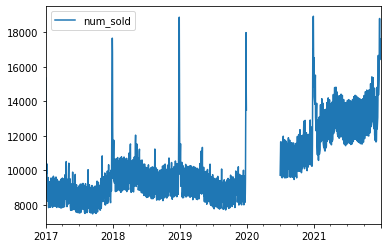

In [49]:
full_df.plot()